# Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
from collections import Counter
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

In [5]:
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.alpha"] = 0.5

pd.set_option('display.max_colwidth', None)

In [6]:
df = pd.read_parquet('../data/npd_wikidata.parquet')

# Dataset Overview

In [7]:
df.sample(5)

,wikidata_url,label,name_in_native_languages,pseudonyms,sex_or_gender,date_of_birth,place_of_birth,country_of_birth,date_of_death,place_of_death,country_of_death,citizenships,occupations,occupation_groups,awards,signature_url,image_url,date_of_image
249852,http://www.wikidata.org/entity/Q4097755,Nick Bougas,<NA>,<NA>,male,1955-01-01,Savannah,United States,NaT,<NA>,<NA>,United States,screenwriter; composer; record producer; film director; film producer,Arts & Culture,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/NickBougas.jpg,NaT
336225,http://www.wikidata.org/entity/Q6169251,Ximena Bohórquez,<NA>,<NA>,female,1956-11-12,Quito,Ecuador,NaT,<NA>,<NA>,Ecuador,physician,Science & Academia,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Ximena%20Bohorquez%20%2812%20de%20noviembre%29.jpg,NaT
175558,http://www.wikidata.org/entity/Q258128,Ron Arad,<NA>,<NA>,male,1958-05-05,Magdiel,Israel,1988-05-05,<NA>,<NA>,Israel,military personnel; aircraft pilot,Public Figures,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Ron%20Arad.jpg,NaT
133036,http://www.wikidata.org/entity/Q19610611,Ayhan Arifağaoğlu,<NA>,<NA>,male,1939-01-01,Borçka,Turkey,1998-01-12,Ankara,Turkey,Turkey,politician,Public Figures,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Ayhan%20Arifa%C4%9Fao%C4%9Flu.png,NaT
11247,http://www.wikidata.org/entity/Q106624432,Xavier Loyá,<NA>,<NA>,male,1934-12-31,Mexico City,Mexico,2020-09-22,Mexico City,Mexico,Mexico,actor,Arts & Culture,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Xavier%20Loy%C3%A1%20en%20El%20%C3%81ngel%20Exterminador%20%281962%29.jpg,NaT


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417937 entries, 0 to 417936
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   wikidata_url              417937 non-null  string        
 1   label                     417937 non-null  string        
 2   name_in_native_languages  100026 non-null  string        
 3   pseudonyms                12879 non-null   string        
 4   sex_or_gender             417526 non-null  string        
 5   date_of_birth             417937 non-null  datetime64[ns]
 6   place_of_birth            416462 non-null  string        
 7   country_of_birth          417937 non-null  string        
 8   date_of_death             115230 non-null  datetime64[ns]
 9   place_of_death            94520 non-null   string        
 10  country_of_death          94570 non-null   string        
 11  citizenships              399770 non-null  string        
 12  oc

In [9]:
df['sex'] = df['sex_or_gender'].apply(
    lambda x: x if pd.notna(x) and x in ['male', 'female'] else pd.NA
)
gender_summary = df['sex'].value_counts(dropna=False).to_frame(name='count')
gender_summary['percentage'] = (df['sex'].value_counts(normalize=True, dropna=False) * 100).round(1).astype(str) + '%'
print("Gender Distribution:")
display(gender_summary)

df['is_alive'] = df['date_of_death'].isna()
alive_summary = df['is_alive'].value_counts(dropna=False).to_frame(name='count')
alive_summary['percentage'] = (df['is_alive'].value_counts(normalize=True, dropna=False) * 100).round(1).astype(str) + '%'
alive_summary.index = alive_summary.index.map({True: 'alive', False: 'deceased'})
alive_summary.index.name = 'is alive'
print('\nDistribution by living status:')
display(alive_summary)

Gender Distribution:


,count,percentage
sex,,
male,311968,74.6%
female,104673,25.0%
<NA>,1296,0.3%



Distribution by living status:


,count,percentage
is alive,,
alive,302707,72.4%
deceased,115230,27.6%


# Demographic Analysis

In [10]:
df['year_of_birth'] = df['date_of_birth'].dt.year
df['year_of_death'] = df['date_of_death'].dt.year
df['age_of_death'] = (df['date_of_death'] - df['date_of_birth']).dt.days // 365

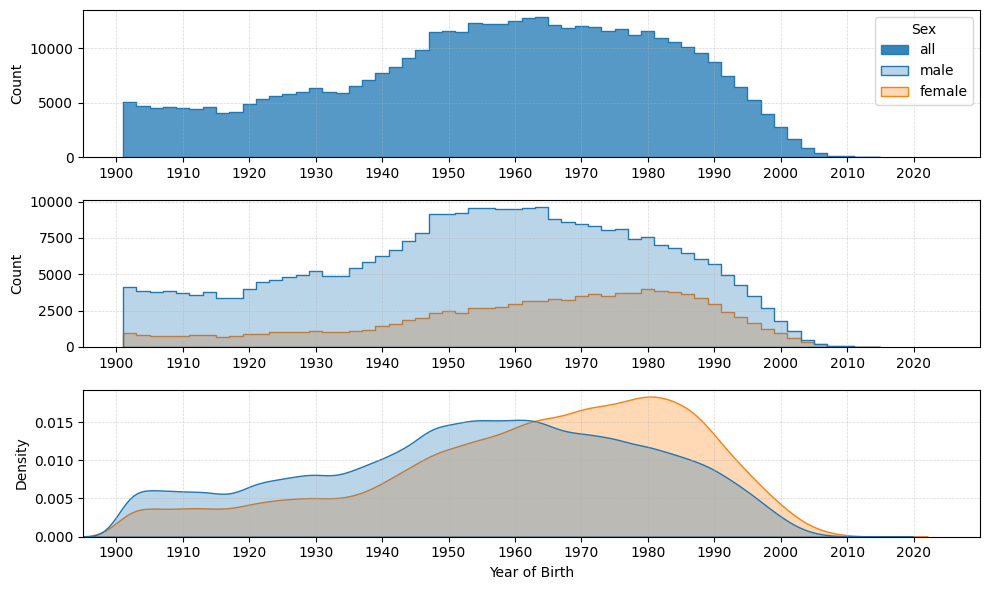

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 6), tight_layout=True, sharex=True)

sns.histplot(df, x="year_of_birth", element="step", binwidth=2, ax=ax1)
sns.histplot(df, x="year_of_birth", hue="sex", element="step", binwidth=2, ax=ax2, alpha=0.3)
sns.kdeplot(df, x="year_of_birth", fill=True, hue='sex', common_norm=False, ax=ax3, alpha=0.3)

tick_values = range(1900, 2030, 10)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1895, 2030)
    ax.set_xticks(tick_values)
    ax.tick_params(axis='x', labelbottom=True)
    if ax.get_legend():
        ax.get_legend().remove()

all_patch = mpatches.Patch(color='C0', label='all', alpha=0.9)
female_patch = mpatches.Patch(facecolor=to_rgba('C1', alpha=0.3), edgecolor='C1', label='female')
male_patch = mpatches.Patch(facecolor=to_rgba('C0', alpha=0.3), edgecolor='C0', label='male')

ax1.legend(
    handles=[all_patch, male_patch, female_patch],
    title="Sex",
)
ax3.set_xlabel('Year of Birth')
plt.show()

In [12]:
def mode(x):
    modes = x.mode()
    return modes[0] if not modes.empty else None


def q25(x):
    return x.quantile(0.25)


def q75(x):
    return x.quantile(0.75)

In [13]:
print('Birth Year Statistics by Sex:')
df.pivot_table(
    index='sex',
    values='year_of_birth',
    aggfunc=['mean', 'median', mode, 'min', 'max'],
    margins=True,              
    margins_name='all'
).apply(np.floor).astype(int).droplevel(level=1, axis=1)

Birth Year Statistics by Sex:


,mean,median,mode,min,max
sex,,,,,
female,1962,1967,1980,1901,2015
male,1954,1956,1964,1901,2014
all,1956,1959,1964,1901,2015


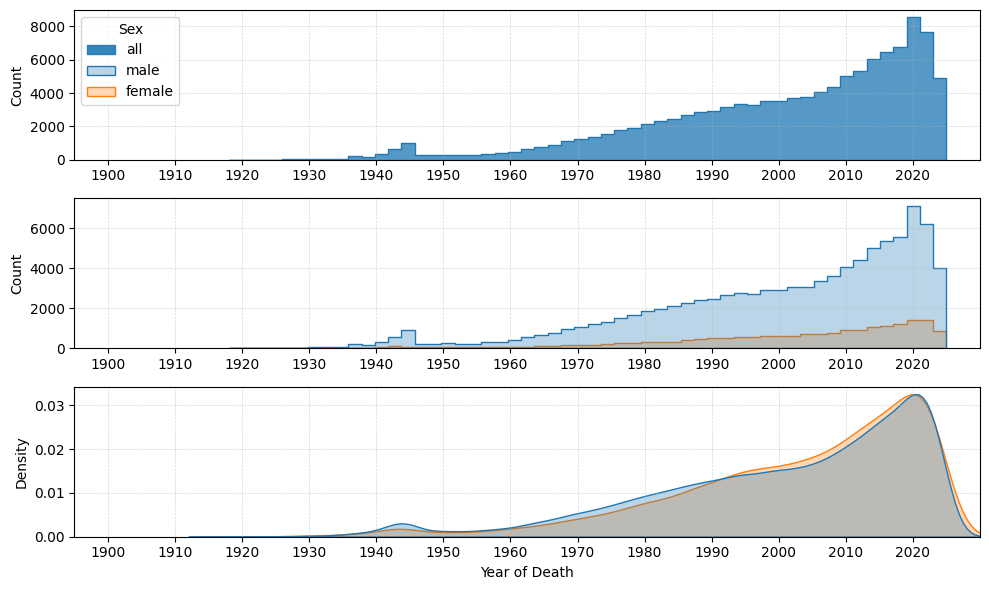

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 6), tight_layout=True, sharex=True)

sns.histplot(df, x="year_of_death", element="step", binwidth=2, ax=ax1)
sns.histplot(df, x="year_of_death", hue="sex", element="step", binwidth=2, ax=ax2, alpha=0.3)
sns.kdeplot(df, x="year_of_death", fill=True, hue='sex', common_norm=False, ax=ax3, alpha=0.3)

tick_values = range(1900, 2030, 10)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1895, 2030)
    ax.set_xticks(tick_values)
    ax.tick_params(axis='x', labelbottom=True)
    if ax.get_legend():
        ax.get_legend().remove()

ax1.legend(
    handles=[all_patch, male_patch, female_patch],
    title="Sex",
    loc='upper left'
)
ax3.set_xlabel('Year of Death')
plt.show()

In [15]:
series = df['year_of_death'].dropna()

kde = gaussian_kde(series)
x = np.linspace(series.min(), series.max(), 100)  
y = kde(x)  

peaks, _ = find_peaks(y)
peak_values = x[peaks]

print('Peaks of Death: ', *np.floor(peak_values).astype(int))

Peaks of Death:  1943 2020


In [16]:
print('Death Year Statistics by Sex:')
df.pivot_table(
    index='sex',
    values='year_of_death',
    aggfunc=['mean', 'median', mode, 'min', 'max'],
    margins=True,              
    margins_name='all'
).apply(np.floor).astype(int).droplevel(level=1, axis=1)

Death Year Statistics by Sex:


,mean,median,mode,min,max
sex,,,,,
female,2002,2008,2021,1922,2025
male,2000,2006,2021,1918,2025
all,2001,2006,2021,1918,2025


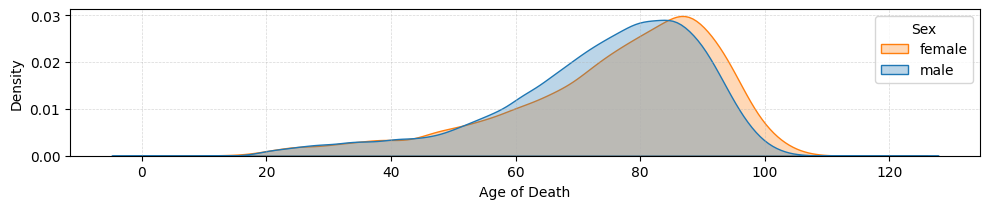

In [17]:
fig, ax = plt.subplots(figsize=(10, 2.2))
sns.kdeplot(df, x="age_of_death", fill=True, hue='sex', common_norm=False, ax=ax, alpha=0.3)
ax.set_xlabel('Age of Death')
ax.legend(title='Sex', labels=['female', 'male'])
plt.tight_layout()
plt.show()

In [18]:
print('Death Age Distribution Statistics by Sex:')
df.pivot_table(
    index='sex',
    values='age_of_death',
    aggfunc=['mean', mode, 'min', q25, 'median', q75, 'max', 'std'],
    margins=True,
    margins_name='all'
).round(1).droplevel(level=1, axis=1)

Death Age Distribution Statistics by Sex:


,mean,mode,min,q25,median,q75,max,std
sex,,,,,,,,
female,75.6,88.0,10.0,67.0,79.0,88.0,119.0,17.1
male,73.7,82.0,0.0,65.0,77.0,85.0,123.0,16.2
all,74.0,84.0,0.0,65.0,77.0,86.0,123.0,16.3


# Geographic Analysis

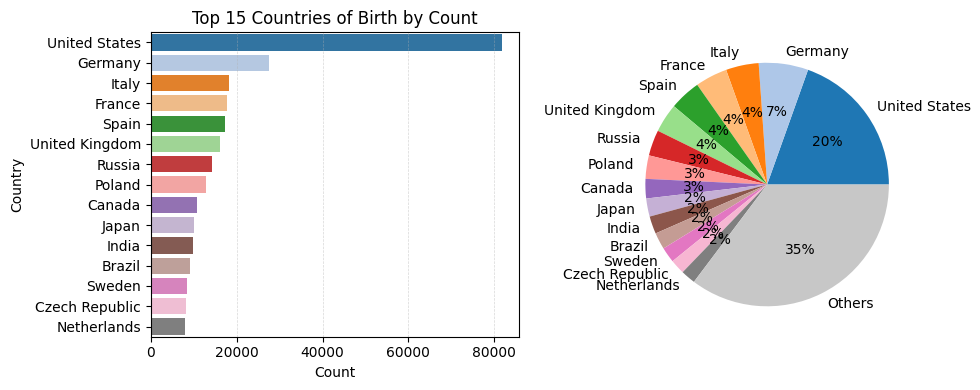

In [19]:
country_counts = df['country_of_birth'].value_counts()
top_countries = country_counts.nlargest(15)
other_countries_count = country_counts.iloc[15:].sum()
combined_countries = pd.concat([top_countries, pd.Series({'Others': other_countries_count})])

country_categories = combined_countries.index.tolist()
country_palette = sns.color_palette('tab20', n_colors=len(country_categories))
country_color_map = dict(zip(country_categories, country_palette))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

country_bar_colors = [country_color_map[country] for country in top_countries.index]
country_pie_colors = [country_color_map[country] for country in combined_countries.index]

sns.barplot(
    x=top_countries.values,
    y=top_countries.index,
    ax=ax1,
    palette=country_bar_colors,
    hue=top_countries.index,
    legend=False
)
ax1.set_title('Top 15 Countries of Birth by Count')
ax1.set_xlabel('Count')
ax1.set_ylabel('Country')

combined_countries.plot(
    kind='pie',
    autopct='%1.0f%%',
    ax=ax2,
    colors=country_pie_colors
)

plt.tight_layout()
plt.show()

In [20]:
print("Total Number of unique Birth Countries:", country_counts.nunique())

top_15_countries = top_countries.reset_index()
top_15_countries.columns = ['country', 'count']
print("\nTop-15 Birth Countries by Count:")
display(top_15_countries)

countries_above_5000 = country_counts[country_counts > 5000]
countries_below_5000 = country_counts[country_counts <= 5000]

count_stats = pd.DataFrame({
    'category': ['Countries with count > 5000', 'Countries with count ≤ 5000'],
    'count': [countries_above_5000.nunique(), countries_below_5000.nunique()],
    'total people': [countries_above_5000.sum(), countries_below_5000.sum()]
})
print("\nCountries grouped by population threshold (5,000):")
display(count_stats)

Total Number of unique Birth Countries: 199

Top-15 Birth Countries by Count:


,country,count
0,United States,81683
1,Germany,27449
2,Italy,18202
3,France,17849
4,Spain,17306
5,United Kingdom,16096
6,Russia,14286
7,Poland,12990
8,Canada,10785
9,Japan,10048



Countries grouped by population threshold (5,000):


,category,count,total people
0,Countries with count > 5000,18,288772
1,Countries with count ≤ 5000,181,129165


In [21]:
place_counts = df['place_of_birth'].value_counts()
print("Total number of unique Birth Places:", place_counts.nunique())

top_15_places = place_counts.nlargest(15).reset_index()
top_15_places.columns = ['place of birth', 'count']
print("\nTop 15 Birth Places by Count:")
display(top_15_places)

Total number of unique Birth Places: 378

Top 15 Birth Places by Count:


,place of birth,count
0,New York City,4145
1,Moscow,3721
2,London,2664
3,Los Angeles,2533
4,Budapest,2490
5,Buenos Aires,2426
6,Paris,2393
7,Prague,2373
8,Warsaw,2308
9,Berlin,2280


In [22]:
place_counts = df['place_of_death'].value_counts()
print("Total number of unique Death Places:", place_counts.nunique())

top_15_places = place_counts.nlargest(15).reset_index()
top_15_places.columns = ['place of death', 'count']
print("\nTop 15 Death Places by Count:")
display(top_15_places)

Total number of unique Death Places: 183

Top 15 Death Places by Count:


,place of death,count
0,Moscow,2232
1,Rome,2095
2,Los Angeles,1701
3,Warsaw,1456
4,New York City,1294
5,Buenos Aires,1169
6,Prague,1133
7,Budapest,1130
8,Berlin,934
9,London,908


# Occupational Analysis

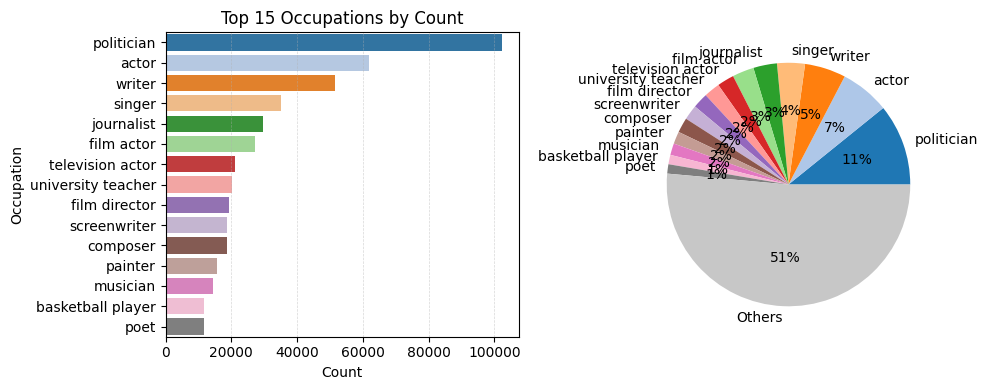

In [23]:
occupations_list = df['occupations'].dropna().str.split(';')
flat_occupations = [occupation.strip() for sublist in occupations_list for occupation in sublist]
occupation_counts = Counter(flat_occupations)

top_occupations = occupation_counts.most_common(15)
occupation_labels, occupation_values = zip(*top_occupations)

other_occupations_count = sum(count for occupation, count in occupation_counts.items() if occupation not in occupation_labels)
combined_occupation_labels = list(occupation_labels) + ['Others']
combined_occupation_values = list(occupation_values) + [other_occupations_count]

occupation_palette = sns.color_palette('tab20', n_colors=len(combined_occupation_labels)+1)
occupation_color_map = dict(zip(combined_occupation_labels, occupation_palette))

occupation_bar_colors = [occupation_color_map[label] for label in occupation_labels]
occupation_pie_colors = [occupation_color_map[label] for label in combined_occupation_labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    x=occupation_values,
    y=occupation_labels,
    ax=ax1,
    palette=occupation_bar_colors,
    hue=occupation_labels
)
ax1.set_title('Top 15 Occupations by Count')
ax1.set_xlabel('Count')
ax1.set_ylabel('Occupation')


ax2.pie(
    combined_occupation_values,
    labels=combined_occupation_labels,
    autopct='%1.0f%%',
    colors=occupation_pie_colors
)

plt.tight_layout()
plt.show()

In [24]:
print("Total number of unique occupations:", len(occupation_counts))

Total number of unique occupations: 5222


In [25]:
df_prof = df.copy()
df_prof = df_prof.assign(
    occupations_split = df_prof['occupation_groups'].str.split(';')
).explode('occupations_split')

df_prof['occupation_group'] = df_prof['occupations_split'].str.strip()
occupation_groups = df_prof['occupation_group'].unique()

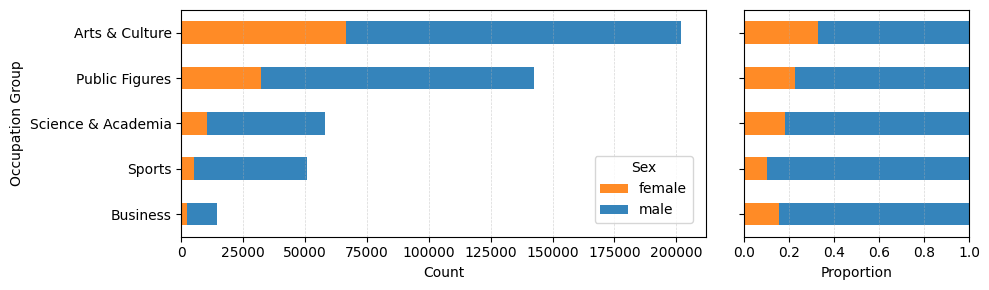

In [26]:
profession_dist = df_prof.groupby(['occupation_group', 'sex']).size().unstack(fill_value=0)
profession_dist = profession_dist.loc[profession_dist.sum(axis=1).sort_values(ascending=True).index]
profession_proportions = profession_dist.div(profession_dist.sum(axis=1), axis=0)

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(10, 3),
    gridspec_kw={'width_ratios': [7, 3]},
    sharey=True
)

profession_dist.plot(
    kind='barh',
    stacked=True,
    ax=ax1,
    color=['C1', 'C0'],
    alpha=0.9
)

ax1.set_xlabel('Count')
ax1.set_ylabel('Occupation Group')
ax1.legend(
    title="Sex",
    loc='best',
    borderaxespad=1,
) 
ax1.yaxis.grid(False)

profession_proportions.plot(
    kind='barh',
    stacked=True,
    ax=ax2,
    legend=False,
    color=['C1', 'C0'],
    alpha=0.9
)
ax2.set_xlim(0, 1)
ax2.set_xlabel('Proportion')
ax2.yaxis.grid(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [27]:
pivot_abs = df_prof.pivot_table(index='occupation_group', columns='sex', aggfunc='size')
pivot_abs.index.name = 'occupation group'
pivot_pct = pivot_abs.div(pivot_abs.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.round(1).astype(str) + '%'
result = pivot_abs.astype(str) + ' (' + pivot_pct + ')'
print('Sex Distribution by Occupation Group (Count and Percentage):')
result

Sex Distribution by Occupation Group (Count and Percentage):


sex,female,male
occupation group,,
Arts & Culture,66433 (32.9%),135630 (67.1%)
Business,2276 (15.7%),12192 (84.3%)
Public Figures,32293 (22.6%),110345 (77.4%)
Science & Academia,10590 (18.2%),47609 (81.8%)
Sports,5215 (10.2%),45744 (89.8%)


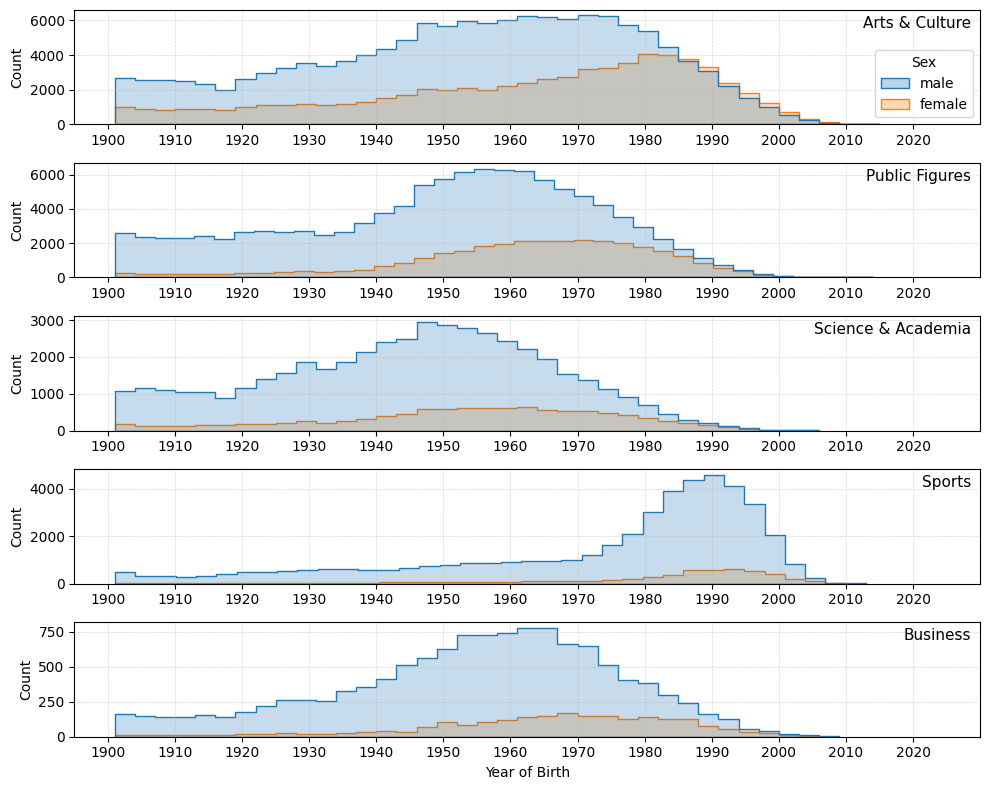

In [28]:
fig, ax = plt.subplots(
    nrows=5,
    figsize=(10, 8),
    tight_layout=True,
    sharex=True,
)
tick_values = range(1900, 2030, 10)

for i in range(5):
    ax[i].set_xlim(1895, 2030)
    ax[i].set_xticks(tick_values)
    sns.histplot(df_prof[df_prof['occupation_group'] == occupation_groups[i]], x="year_of_birth",
                  hue='sex', element="step", binwidth=3, ax=ax[i], legend=(i==0))
    ax[i].annotate(
        occupation_groups[i],
        xy=(0.99, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        fontsize=11,
    )        
    ax[i].tick_params(axis='x', labelbottom=True)
ax[0].legend(
    handles=[male_patch, female_patch],
    title="Sex", loc='lower right'
)
ax[-1].set_xlabel('Year of Birth')
plt.show()

In [29]:
year_pivot = df_prof.pivot_table(
    index='occupation_group',
    columns='sex',
    values='year_of_birth',
    aggfunc=mode,
    margins=True,
    margins_name='overall'
)
year_pivot.index.name = 'occupation group'
year_pivot['mode difference (f-m)'] = year_pivot['female'] - year_pivot['male']

print('Mode of Birth Year by Sex and Occupation Group:')
year_pivot.apply(np.floor).astype(int)

Mode of Birth Year by Sex and Occupation Group:


sex,female,male,overall,mode difference (f-m)
occupation group,,,,
Arts & Culture,1980,1964,1980,16
Business,1973,1964,1964,9
Public Figures,1971,1956,1960,15
Science & Academia,1962,1947,1947,15
Sports,1993,1990,1989,3
overall,1980,1964,1964,16


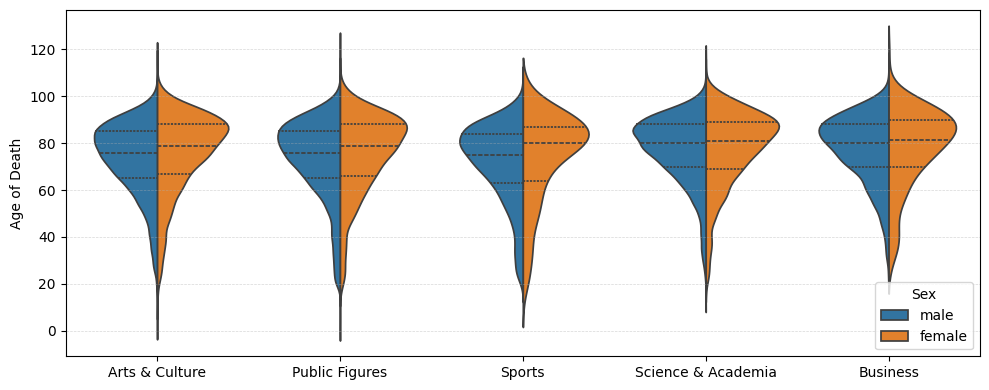

In [30]:
df_vplot = df_prof.dropna(subset=['age_of_death', 'sex', 'occupation_group'])

fix, ax = plt.subplots(figsize=(10, 4))

sns.violinplot(
    data=df_vplot,
    x='occupation_group',
    y='age_of_death',
    hue='sex', split=True, inner="quart", ax=ax, palette='tab10')
ax.legend(title='Sex', loc='lower right')  

plt.xlabel('')
plt.ylabel('Age of Death')
plt.tight_layout()
plt.show()

In [31]:
age_pivot = df_prof.pivot_table(
    index='occupation_group',  
    columns='sex',           
    values='age_of_death',     
    aggfunc='mean',            
    fill_value=None,           
    margins=True,              
    margins_name='overall'
)
age_pivot.index.name = 'occupation group'
age_pivot['mean gap (f-m)'] = age_pivot['female'] - age_pivot['male']
print('Mean Age of Death by Sex and Occupation Group:')
age_pivot.round(1)

Mean Age of Death by Sex and Occupation Group:


sex,female,male,overall,mean gap (f-m)
occupation group,,,,
Arts & Culture,75.5,73.4,73.9,2.1
Business,77.9,77.7,77.7,0.2
Public Figures,75.2,73.0,73.2,2.2
Science & Academia,77.7,77.3,77.3,0.4
Sports,73.8,71.5,71.6,2.3
overall,75.7,73.9,74.2,1.8


# Cross Analysis: Occupation & Country

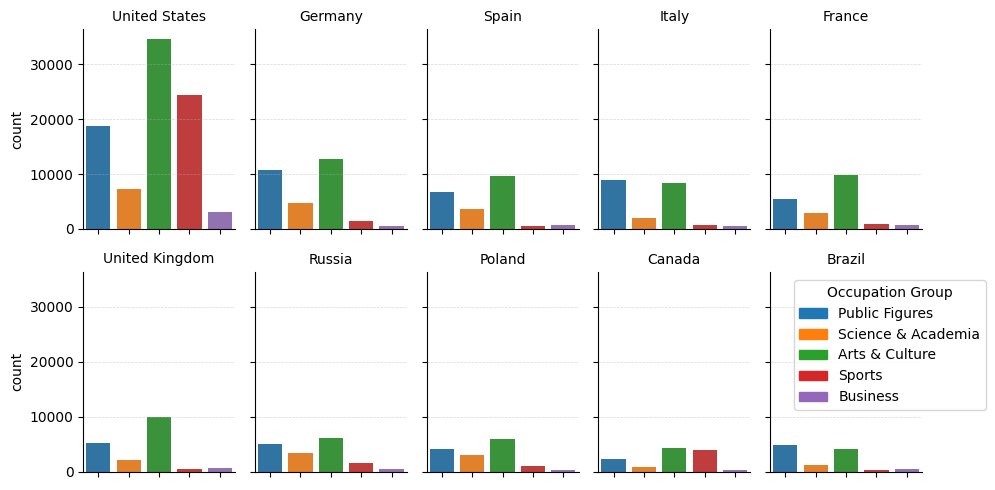

In [35]:
top_10_countries = df_prof['country_of_birth'].value_counts().head(10).index.tolist()
df_top_10_countries = df_prof[df_prof['country_of_birth'].isin(top_10_countries)]

g = sns.catplot(
    data=df_top_10_countries,
    x='occupation_group',
    kind='count',
    hue='occupation_group',
    col='country_of_birth',
    col_wrap=5,
    col_order=top_10_countries,
    palette='tab10',
    height=2.5,
    aspect=0.6,    
)
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.set_xticklabels([])
    ax.set_xlabel('')

unique_categories = df_top_10_countries['occupation_group'].unique()
palette = sns.color_palette('tab10', n_colors=len(unique_categories))
legend_data = dict(zip(unique_categories, [plt.Rectangle((0,0),1,1, color=col) for col in palette]))
g.add_legend(title='Occupation Group', legend_data=legend_data, bbox_to_anchor=(0.95, 0.3), loc='center', frameon=True)

plt.tight_layout()
plt.show()

In [33]:
pivot_countries = df_top_10_countries.pivot_table(
    index='country_of_birth', 
    columns='occupation_group', 
    aggfunc='size'
).astype(int)
pivot_countries.columns.name = 'occupation group'
pivot_countries.index.name = 'country of birth'
pivot_countries = pivot_countries.reindex(top_10_countries)
pivot_countries = pivot_countries[['Public Figures', 'Science & Academia', 'Arts & Culture', 'Sports', 'Business']]

print('Count of Individuals by Occupation Groups in Top 10 Birth Countries:')
pivot_countries.style.background_gradient(cmap='Blues', axis=0)

Count of Individuals by Occupation Groups in Top 10 Birth Countries:


occupation group,Public Figures,Science & Academia,Arts & Culture,Sports,Business
country of birth,,,,,
United States,18861,7346,34659,24478,3110
Germany,10673,4772,12672,1486,632
Spain,6676,3617,9602,633,678
Italy,8902,2095,8443,705,604
France,5428,2942,9829,888,766
United Kingdom,5147,2006,9912,442,677
Russia,5026,3402,6148,1469,529
Poland,4151,3039,5995,1073,191
Canada,2235,754,4264,3987,274


# Summary & Observations

The analysis reveals several notable patterns in the dataset:

**Gender disparity**: The dataset is notably skewed toward men — 74.6% male vs. 25% female.

**Living status**: About **72% of individuals are still alive** (based on available records), which makes sense given the dataset includes only people born since 1901.

**Birth year patterns**:
  - The distribution of birth years shows a clear concentration of individuals born between the **1950s and 1990s**.
  - This is likely due to the rise of **Wikipedia in the 2000s**, which brought increased visibility and documentation for people who became notable around that time or were already prominent by then.
  
**Mortality patterns**:
  - There is a clear **increase in death counts toward the 21st century**, which is expected given the birth year restriction (from 1901 onward).
  - Two **distinct peaks in death years** are noticeable — one around **1943**, likely reflecting wartime casualties, and another around **2020**, potentially influenced by the COVID-19 pandemic.

**Age at death**:
  - The overall distribution of death age is fairly realistic, but some **extreme outliers** (e.g., age 0 or over 120) are present.
  - These are likely due to **data entry errors or inconsistencies in Wikidata**, and should be interpreted with caution.

**Geographic distribution**:
  - The **United States** dominates with nearly 20% of the records, followed by Germany, Italy, France, and Spain.
  - Only **18 countries** have over 5,000 individuals; most countries are underrepresented.

**Occupational insights**:
  - The most represented group is **Arts & Culture**, followed by **Public Figures**.
  - **Gender disparity varies by occupation**: Women are best represented in **Arts & Culture (33%)**, and least in **Sports (10%)**.
  - Notably, the **mode birth years for women are more recent** than for men in all occupation groups.

**Mortality by occupation**:
  - Across all groups, **women tend to live longer** by about 1.8 years on average.
  - The highest average life expectancy is found in **Business** and **Science & Academia** (\~77 years), while **Sports** has the lowest (\~71–73 years).


> **Note**:  
> This dataset reflects only the subset of people who are present in **Wikidata** and meet specific filtering criteria (e.g., having a known birth year and a public image). As such, it does **not represent the global population** or even all notable individuals.
> 
> Some occupational or geographic categories may be **underrepresented** or contain **too few records** to support statistically meaningful conclusions. Any interpretations should be considered **exploratory**, and not definitive.

